# System of Equations

Let's motivate this section with  the __Lotka-Volterra equations__, also known as the predator-prey equations, are a pair of first-order nonlinear differential equations, frequently used to describe the dynamics of biological systems in which two species interact. The populations change through time according to the pair of equations:

$$
\dfrac{dx}{dt} = \alpha x - \beta xy \\
\dfrac{dy}{dt} = -\gamma y + \delta xy
$$

where
- $x$ is the number of prey;
- $y$ is the number of some predator;
- ${\tfrac {dy}{dt}}$ and ${\tfrac {dx}{dt}}$ represent the instantaneous growth rates of the two populations;
- $t$ represents time;
- $\alpha$, $\beta$, $\gamma$ and $\delta$ are positive real parameters describing the interaction of the two species.

## Physics-Informed Neural Networks

For years mathematicians and physicists are trying to model the world with differential equations. However, since the advent of techniques such as machine learning, neural networks and deep learning together with greater computing power, community has speculated that we could learn automatically (algorithms) anything with a enough amount of data. However, it seems this is not really true.

Philosophical Question: Could have a _machine_ discovered Newton's laws?

In 2019, Raissi, Perdikaris and Karniadakis introduced Physics-Informed Neural Networks (PINNs), neural networks that are trained to solve supervised learning tasks while respecting any given law of physics described by general nonlinear partial differential equations ([source](https://www.sciencedirect.com/science/article/pii/S0021999118307125)). PINNs are nowadays used to solve PDEs, fractional equations, and integral-differential equations.

PINNs approximate PDE solutions by training a neural network to minimize a loss function, including:

* Initial and boundary conditions along the space-time domain’s boundary
* PDE residual at selected points in the domain.

If you want to do a simplified analogy, initial and boundary conditions points will be an usual training dataset, but also it is necessary to embed physical laws (PDE) into the neural network.

PINNs can solve differential equations expressed, in the most general form, like:

$$
\begin{align*}
\mathcal{F}(u(z); \lambda) &= f(z) \quad z \text{ in } \Omega \\
\mathcal{B}(u(z)) &= g(z) \quad z \text{ in } \partial \Omega
\end{align*}
$$ 

defined on the domain $\Omega \subset \mathbb{R}^d$ with the boundary $\partial \Omega$. Where
- $z := (x_1, x_2, \ldots, t)^\top$ indicated the space-time coordinate vector,
- $u$ the unknown function,
- $\lambda$ the parameters related to the physics,
- $\mathcal{F}$ the non-linear differential operator,
- $f$ the function identifying the data of the problem,
- $\mathcal{B}$ the operator indicating arbitrary initial or boundary conditions, and
- $g$ the boundary function.

In the PINN methodology, $u(z)$ is computationally predicted by a NN, parametrized by a set of parameters $\theta$, giving rise to an approximation
$$
\hat{u}_\theta(z) \approx u(z)
$$

The optimization problem we want to deal with it is

$$
\min_\theta \; \omega_\mathcal{F} \mathcal{L}_\mathcal{F}(\theta) + \omega_\mathcal{B} \mathcal{L}_\mathcal{B}(\theta) + \omega_{\text{data}} \mathcal{L}_{\text{data}}(\theta)
$$

this is three weighted loss functions, each one depending on
- $\mathcal{L}_\mathcal{F}$, differential equation, 
- $\mathcal{L}_\mathcal{B}$, boundary conditions, and
- $\mathcal{L}_{\text{data}}$, (eventually) some known data.

![PINNs](https://media.springernature.com/full/springer-static/image/art%3A10.1007%2Fs10915-022-01939-z/MediaObjects/10915_2022_1939_Fig2_HTML.png?as=webp)

[Source](https://link.springer.com/article/10.1007/s10915-022-01939-z)

## PINNs solving ODEs

For our Lotka-Volterra system the solution $u$ will be a vector such that 
$$
u(t) = (x(t), y(t))^\top
$$
and there are not boundary conditions, only initial conditions.

We want to train a network that looks like this

![lotka_volterra_pinn](../images/lotka_volterra_pinn.png)

## Import packages

The most important package is `deepxde`, which allows us to implement Physic-Informed Neural Networs approaches with a few lines of code. We will need `numpy` for array operations, `matplotlib` for visualizations and `scipy` for getting the real solution (which is not always possible, if not we would only use this approach).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import deepxde as dde

from scipy.integrate import solve_ivp
from deepxde.backend import tf

Using backend: tensorflow.compat.v1

2023-03-08 23:52:18.602999: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-08 23:52:18.836390: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-08 23:52:19.547635: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/alonsolml/mambaforge/envs/pinn/

Instructions for updating:
non-resource variables are not supported in the long term


2023-03-08 23:52:20.575767: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-03-08 23:52:20.617238: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-03-08 23:52:20.617290: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


Enable just-in-time compilation with XLA.




## ODE Residuals

Since we are trying to embed the physics onto the neural networks we need to define 

In [2]:
alpha = 2 / 3
beta = 4 / 3
gamma = 1
delta = 1

In [3]:
def ode(t, Y):
    x = Y[:, 0:1]
    y = Y[:, 1:2]

    dx_dt = dde.grad.jacobian(Y, t, i=0)
    dy_dt = dde.grad.jacobian(Y, t, i=1)
    
    return [
        dx_dt - alpha * x + beta * x * y,
        dy_dt + gamma * y  - delta * x * y
    ]

Here `t` is the indepent variable and `Y` is an array with two columns (since our system considers two equations). To define the first derivative is as easy as using `dde.grad.jacobian`, just be sure about the component `i`, in this case we decided `i=0` corresponds to the variable $x(t)$ and `i=1` to $y(t)$.

## Initial conditions

It is important to decide a time invertal where we will working on. As an example let's consider between $t=0$ and $t=1$.

In [4]:
t_initial = 0
t_final = 10

And now we need to declare this element for our neural network, if not, the algorithm wouldn't know where to make the estimations.

In [5]:
geom = dde.geometry.TimeDomain(t_initial, t_final)

Then we have to create a function for defining boundaries, since our geometry it is only on time we will use the default one, don't worry about it.

In [6]:
def boundary(_, on_initial):
    return on_initial

Let's choose initial conditions for $x$ and $y$

In [7]:
x0 = 1.2
y0 = 0.8

And then we have to tell to our algorithm these are the initial conditions for the learning process

In [8]:
ic_x = dde.icbc.IC(geom, lambda x: x0, boundary, component=0)
ic_y = dde.icbc.IC(geom, lambda x: y0, boundary, component=1)

## Data object

Everything related to the differential equations and initial conditions has to be inside a new object `dde.data.PDE` (do not worry, it also consider systems of ordinary differential equations).

In [9]:
data = dde.data.PDE(
    geom,
    ode,
    [ic_x, ic_y],
    num_domain=512,
    num_boundary=2
)

In order to test our model we need more points, we considered 512 points inside our domain with `num_domain=512`. Finally, since we are working on a time domain there are only two points in its boundary (`num_boundary=2`).

## Neural Network

It is time for choosing a neural network architecture. For simplicity, we will use a Fully-connected neural network (`dde.nn.FNN'). The most important things are:

- Input layer (the first one) needs only one node/neuron since our indepent variable is only time $t$.
- The output layer (the last one) nneds two nodes/neurons since we are working on a system of two equations.

Do not worry so much about the amount of layers or neurons in each hidden layer, as a rule of thumb error should decrease while you add more layers and neurons, but it will take more computational time. Activation functions and the initializer are more parameters the user must choose, usually `Glorot normal` works well as initializer. However, we would recommend you to try different activation functions, for example, `relu`, `sigmoid` or `swish`.

In [10]:
neurons = 64
layers = 6
activation = "tanh"
initializer = "Glorot normal"
net = dde.nn.FNN([1] + [neurons] * layers + [2], activation, initializer)

## Model

The library we are working with needs put everything together in a new object, but it is just one line of code.

In [11]:
model = dde.Model(data, net)

## Training

For training we will go with an Adam optimizer (a very popular one nowadays) and a learning rate of 0.001 (smaller learning rates may give you better results but it will take many more iterations).

Just for simplicity we will take 50000 iterations, but another rule of thumb it is that as you increase the number of iterations the loss value should decrease as well.

In [12]:
model.compile("adam", lr=0.001)
losshistory, train_state = model.train(iterations=50000)

Compiling model...
Building feed-forward neural network...
'build' took 0.040565 s



/home/alonsolml/mambaforge/envs/pinn/lib/python3.10/site-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:103: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(
2023-03-08 23:52:21.664921: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-08 23:52:21.666828: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-03-08 23:52:21.666901: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file t

'compile' took 1.516456 s

Initializing variables...
Training model...



2023-03-08 23:52:23.153795: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:357] MLIR V1 optimization pass is not enabled
2023-03-08 23:52:23.245816: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7fd4ac00dc90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-03-08 23:52:23.245850: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2023-03-08 23:52:23.261003: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-03-08 23:52:23.546447: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: Permission denied
2023-03-08 23:52:23.651611: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Step      Train loss                                  Test loss                                   Test metric
0         [2.38e-01, 6.60e-01, 1.44e+00, 6.40e-01]    [2.38e-01, 6.60e-01, 1.44e+00, 6.40e-01]    []  


2023-03-08 23:52:24.295353: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


1000      [6.37e-04, 1.01e-03, 2.19e-06, 1.69e-05]    [6.37e-04, 1.01e-03, 2.19e-06, 1.69e-05]    []  
2000      [3.23e-04, 7.10e-04, 6.89e-07, 3.31e-06]    [3.23e-04, 7.10e-04, 6.89e-07, 3.31e-06]    []  
3000      [2.13e-04, 8.49e-04, 1.82e-05, 5.48e-06]    [2.13e-04, 8.49e-04, 1.82e-05, 5.48e-06]    []  
4000      [5.64e-04, 5.86e-04, 2.10e-05, 1.32e-06]    [5.64e-04, 5.86e-04, 2.10e-05, 1.32e-06]    []  
5000      [3.61e-05, 6.59e-05, 4.58e-07, 4.43e-07]    [3.61e-05, 6.59e-05, 4.58e-07, 4.43e-07]    []  
6000      [1.22e-05, 8.46e-06, 1.27e-07, 6.34e-08]    [1.22e-05, 8.46e-06, 1.27e-07, 6.34e-08]    []  
7000      [8.38e-06, 1.06e-05, 6.62e-06, 3.26e-07]    [8.38e-06, 1.06e-05, 6.62e-06, 3.26e-07]    []  
8000      [6.72e-06, 5.98e-06, 1.21e-06, 5.01e-09]    [6.72e-06, 5.98e-06, 1.21e-06, 5.01e-09]    []  
9000      [2.94e-06, 6.62e-07, 3.00e-07, 4.81e-07]    [2.94e-06, 6.62e-07, 3.00e-07, 4.81e-07]    []  
10000     [6.34e-05, 7.44e-06, 1.65e-08, 3.67e-06]    [6.34e-05, 7.44e-06

In [13]:
# model.compile("L-BFGS")
# losshistory, train_state = model.train()

We can plot the loss history with a simple command.

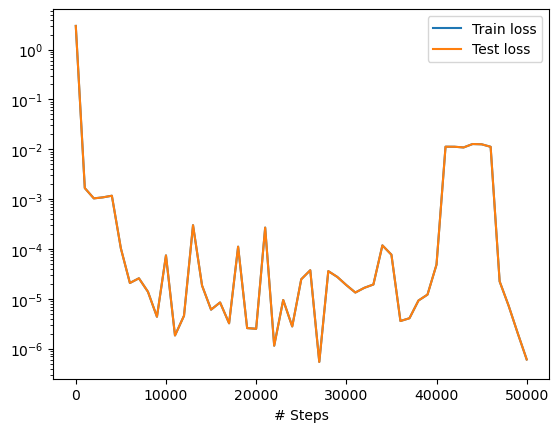

In [14]:
dde.utils.external.plot_loss_history(losshistory)

## Compare

Now it is time to compare our model. We chose the Lotka-Volterra because we can obtain the solution with a Runge-Kuta algorithm, for instance, we used `solve_ivp` from `scipy`.

In [15]:
def generate_data(
    t,
    x0,
    y0,
    alpha,
    beta,
    gamma,
    delta
):

    def func(t, Y):
        x, y = Y
        dx_dt = alpha * x - beta * x * y
        dy_dt = - gamma * y  + delta * x * y
        return dx_dt, dy_dt

    Y0 = [x0, y0]
    t_span = (t[0], t[-1])
    sol = solve_ivp(func, t_span, Y0, t_eval=t)
    x_true, y_true = sol.y
    return x_true, y_true

Let's generate a fine grid of time, generate data with Runge-Kuta and then compare both approaches in the same plot.

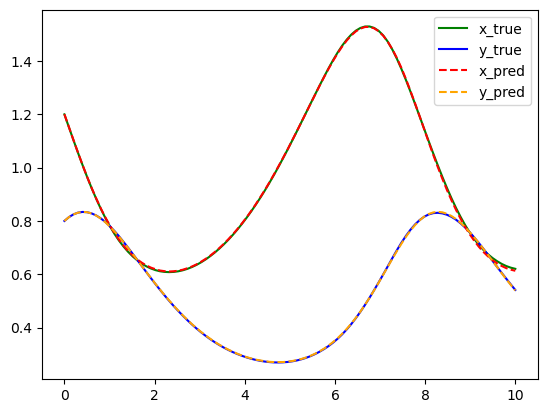

In [16]:
t = np.linspace(t_initial, t_final, 100)
x_true, y_true = generate_data(t, x0, y0, alpha, beta, gamma, delta)
plt.plot(t, x_true, color="green", label="x_true")
plt.plot(t, y_true, color="blue", label="y_true")

sol_pred = model.predict(t.reshape(-1, 1))
x_pred = sol_pred[:, 0:1]
y_pred = sol_pred[:, 1:2]

plt.plot(t, x_pred, color="red", linestyle="dashed", label="x_pred")
plt.plot(t, y_pred, color="orange", linestyle="dashed", label="y_pred")
plt.legend()
plt.show()

As you can see both algorithms gave us almost identical results. One of the pros that we would like to point out about Physics-Informed neural networks is that for more complex systems you only need to change a very few things more, specifically residuals. Most of the numerical work is done automatically by machine learning libraries as `TensorFlow`, `Torch`, `JAX`, etc. so it is easy to scale it up, even better when we can take advantage of GPUs. For you, as an user, your challenge will be in pick suitable hyper-parameters (number of layers, number of neurons, activation function, number of iterations, etc.) but this also could be done by other algorithms, however these are out of the scope of this lesson.